In [119]:
import datetime
from unittest import result
from loguru import logger
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import global_const as gconst
import numpy as np
import pickle
from lifelines import KaplanMeierFitter,CoxPHFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import logrank_test,multivariate_logrank_test
from scipy import stats
from tqdm import tqdm

from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import MultiComparison

from pathlib import Path


# import data

In [120]:
# import 

data_path_prefix = "./esrd"
project_path_prefix = "./"

origin_data_path=f"{data_path_prefix}/origin/ckd/"
data_path=f"{data_path_prefix}/processed/"
result_path=f"{project_path_prefix}/result/"

Path(result_path).mkdir(parents=True, exist_ok=True)


pdid_656 = pickle.load(open(f'{data_path}656_pdid','rb'))
days_656 = pickle.load(open(f'{data_path}656_days','rb'))
date_656 = pickle.load(open(f'{data_path}656_date','rb'))
visit_sta = pickle.load(open(f'{data_path}statistics_visit','rb'))
diet_sta = pickle.load(open(f'{data_path}statistics_diet','rb'))
visit_sta_first = pickle.load(open(f'{data_path}statistics_visit_first','rb'))
visit_sta_mean = pickle.load(open(f'{data_path}statistics_visit_mean','rb'))
diet_sta_first = pickle.load(open(f'{data_path}statistics_diet_first','rb'))
diet_sta_mean = pickle.load(open(f'{data_path}statistics_diet_mean','rb'))

labels_visit_sta = gconst.get_labels_statistics_visit()
labels_diet_sta = gconst.get_labels_statistics_diet()


In [121]:
# 查看 gender 
a = np.array(visit_sta_first)
print(f'count of male:{sum(a[:,18])}, ratio:{sum(a[:,18])/len(a)}')
print(f'count of diab:{sum(a[:,19])}, ratio:{sum(a[:,19])/len(a)}')


count of male:329.0, ratio:0.5015243902439024
count of diab:244.0, ratio:0.3719512195121951


# KM survival analysis for all visits

In [122]:
def append_livedatas(pdid,visit_single,days,labels=gconst.get_labels_statistics_visit()):
    """在统计指标的基础上，增加 live_time 和death两个指标"""
    labels_days = gconst.get_labels_days()
    res = []
    for index in range(len(pdid)):
        death_day = days[index][labels_days.index('death_day')]
        admission_day = days[index][labels_days.index('admission_day')]
        death = days[index][labels_days.index('death')]  
        cure_time = (datetime.datetime.strptime(death_day,'%Y/%m/%d')-datetime.datetime.strptime(admission_day,'%Y/%m/%d')).days/365
        live_data = [cure_time,death]
        cur_data = list(visit_single[index]) + live_data
        res.append(cur_data)
    labels_appended = labels + ['live_time','death']
    return res,labels_appended

In [123]:
res, labels = append_livedatas(pdid_656,visit_sta_first,days_656)

In [124]:
def get_groups(col,data_df,q):
    '''获取组
    @param col：列
    @param data_df: 数据
    @param q：分层数
    @return group_counts: 组
    @return groups:分别属于哪组
    @return data_rounds:组的数据范围
    '''
    cols = list(data_df.keys())
    datas = data_df.values
    if col == 'diab' or col == 'gender':
        group_counts = [0,1] # 分组
        groups = data_df[col]
        data_rounds = [(0,0),(1,1)]
    elif col == 'all':
        group_counts = [0]
        groups = data_df[col]
        data_rounds = [(0,0)]

    else :
        group_counts = list(range(q))
        index = cols.index(col)
        cur_data = datas[:,index]
        
        data_rounds = gconst.get_data_rounds(cur_data,'q'+str(q))
        cur_data_stage = gconst.get_data_rounds_indexs(cur_data,data_rounds)
        # cur_df = data_df[['live_time','death']]
        cur_df = data_df[[col]]
        cur_df.insert(cur_df.shape[1],f'{col}_stage',cur_data_stage)
        groups = cur_df[f'{col}_stage']
    return group_counts, groups, data_rounds

def do_lifelines(pdid,visit_single,days,result_path,save,confi,col,labels,q):
    """KM法生存分析，输出km曲线图和生存范围结果"""
        # print(labels)
    datas,cols = append_livedatas(pdid_656,visit_single,days_656)
    datas = np.array(datas)
    df = pd.DataFrame(datas,columns=cols)
    df.insert(df.shape[1],column='all',value=0)
    
    kmf = KaplanMeierFitter()
    ax = ''
    confi50s = []
    
    group_counts, groups, data_rounds = get_groups(col,df,q)
    # log rank
    result = multivariate_logrank_test(df[['live_time']],groups,df[['death']])
    # result.print_summary()
    p_value = result.p_value

    for i in group_counts:
        ix = (groups == i)
        kmf.fit(df['live_time'][ix],df['death'][ix],label=labels[i])
        treatment_median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
        median_survival_time_ = kmf.median_survival_time_
        npm = treatment_median_confidence_interval_.to_numpy()[0]
        confi50s.append([median_survival_time_]+list(npm))
        if ax == '':
            ax = kmf.plot(ci_show=confi) # at_risk_counts=True
        else :
            ax = kmf.plot(ax = ax,ci_show=confi,)
    if save:
        Path(f'{result_path}lifelines').mkdir(parents=True, exist_ok=True)
        if confi:
            # print(gconst.get_data_rounds_str(data_rounds))

            ax.set_title(f'{col}_lifelines_confi')
            ax.get_figure().savefig(f'{result_path}lifelines/{col}_lifelines_confi.png')
            plt.close(ax.get_figure())
            bound_df = pd.DataFrame(confi50s,index=labels,columns=['median','lower','upper'])
            filename=f'{result_path}lifelines/{col}_lifelines_confi.xlsx'
            with pd.ExcelWriter(filename) as writer:
                bound_df.to_excel(writer,float_format='%.4f')
                logger.debug(f'result saved as {filename}')
        else:
            ax.set_title(f'{col}_lifelines')
            ax.get_figure().savefig(f'{result_path}lifelines/{col}_lifelines.png')
            plt.close(ax.get_figure())
            # plt.close()
    return p_value,confi50s

In [125]:
import collections
def get_data_rounds_allcol(pdid_656, visit_single, days_656, q, result_path):
    '''分组范围'''
    datas,cols = append_livedatas(pdid_656,visit_single,days_656)
    datas = np.array(datas)
    df = pd.DataFrame(datas,columns=cols)
    df.insert(df.shape[1],column='all',value=0)
    res = {'cols':cols,'rounds':[],'count':[]}
    for col in cols:
        group_counts, groups, data_rounds = get_groups(col,df,q)
        # print(gconst.get_data_rounds_str(data_rounds))
        # print(data_rounds)
        res['rounds'].append(gconst.get_data_rounds_str(data_rounds))
        c = collections.Counter(groups)
        res['count'].append(dict(c))
    filename = f'{result_path}data_rounds_allcol.xlsx'
    res_df = pd.DataFrame(res)
    with pd.ExcelWriter(filename) as writer:
        res_df.to_excel(writer,float_format='%.4f')
        logger.debug(f'result saved as {filename}')
get_data_rounds_allcol(pdid_656,visit_sta_first,days_656,3,result_path)

2024-04-05 11:04:28.262 | DEBUG    | __main__:get_data_rounds_allcol:20 - result saved as .//result/data_rounds_allcol.xlsx


## Perform KM analysis for each indicator group

In [126]:
# 做每个指标的分组KM分析
save = True
res = []
q = 3
p_value,confi50s = do_lifelines(pdid_656,visit_sta_first,days_656,result_path,save,confi=True,col='diab',labels=['no diab','diab'], q=3)
res.append(['diab',p_value])
p_value,confi50s = do_lifelines(pdid_656,visit_sta_first,days_656,result_path,save,confi=False,col='diab',labels=['no diab','diab'], q=3)

p_value,confi50s = do_lifelines(pdid_656,visit_sta_first,days_656,result_path,save,confi=True,col='gender',labels=['female','male'], q=3)
res.append(['gender',p_value])
p_value,confi50s = do_lifelines(pdid_656,visit_sta_first,days_656,result_path,save,confi=False,col='gender',labels=['female','male'], q=3)
cols =  gconst.get_labels_visit() + ['age','height','bmi','gfr']
# cols = ['age','height']

for col in cols:
    p_value,confi50s = do_lifelines(pdid_656,visit_sta_first,days_656,result_path,save,confi=True,col=col,labels=[f'{col}_{i}' for i in range(3)], q=3)
    do_lifelines(pdid_656,visit_sta_first,days_656,result_path,save,confi=False,col=col,labels=[f'{col}_{i}' for i in range(3)], q=3)
    res.append([f'{col}',p_value])

col = 'all'
p_value,confi50s = do_lifelines(pdid_656,visit_sta_first,days_656,result_path,save,confi=True,col=col,labels=[f'{col}'],q=q)
do_lifelines(pdid_656,visit_sta_first,days_656,result_path,save,confi=False,col=col,labels=[f'{col}'],q=q)


2024-04-05 11:04:28.454 | DEBUG    | __main__:do_lifelines:75 - result saved as .//result/lifelines/diab_lifelines_confi.xlsx
2024-04-05 11:04:28.732 | DEBUG    | __main__:do_lifelines:75 - result saved as .//result/lifelines/gender_lifelines_confi.xlsx


2024-04-05 11:04:29.029 | DEBUG    | __main__:do_lifelines:75 - result saved as .//result/lifelines/Cl_lifelines_confi.xlsx
2024-04-05 11:04:29.350 | DEBUG    | __main__:do_lifelines:75 - result saved as .//result/lifelines/CO2CP_lifelines_confi.xlsx
2024-04-05 11:04:29.673 | DEBUG    | __main__:do_lifelines:75 - result saved as .//result/lifelines/WBC_lifelines_confi.xlsx
2024-04-05 11:04:29.992 | DEBUG    | __main__:do_lifelines:75 - result saved as .//result/lifelines/Hb_lifelines_confi.xlsx
2024-04-05 11:04:30.313 | DEBUG    | __main__:do_lifelines:75 - result saved as .//result/lifelines/Urea_lifelines_confi.xlsx
2024-04-05 11:04:30.631 | DEBUG    | __main__:do_lifelines:75 - result saved as .//result/lifelines/Ca_lifelines_confi.xlsx
2024-04-05 11:04:31.165 | DEBUG    | __main__:do_lifelines:75 - result saved as .//result/lifelines/K_lifelines_confi.xlsx
2024-04-05 11:04:31.484 | DEBUG    | __main__:do_lifelines:75 - result saved as .//result/lifelines/Na_lifelines_confi.xlsx
202

(nan, [[6.1506849315068495, 5.64931506849315, 6.835616438356165]])

## output p-value

In [127]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
df = pd.DataFrame(res,columns=['label','p_value'])
# print(df[df['p_value']<0.01])
# print(df)
filename = f'{result_path}km_p_value.xlsx'
with pd.ExcelWriter(filename) as writer:
    df.to_excel(writer,float_format='%.4f')
    logger.debug(f'result saved as {filename}')


2024-04-05 11:04:36.307 | DEBUG    | __main__:<module>:8 - result saved as .//result/km_p_value.xlsx


# Analysis of good and bad diet groups


In [128]:
def get_medium_time(pdid,visit_single,days,result_path,save,cols,q):
    '''获取中位生存时间'''
    result = {}
    for col in cols:
        coef =  do_lifelines(pdid_656,visit_single,days_656,result_path,save=False,confi=True,col=col,labels=[f'{col}_{i}' for i in range(q)],q = q)
        result[col] = coef
    return result

[(19.45205479452055, 53.05986301369863), (53.05986301369863, 67.59041095890412), (67.59041095890412, 102.21369863013699)]
{'age': (5.487633988747042e-26, [[10.284931506849315, 9.517808219178082, 10.693150684931506], [6.616438356164384, 5.936986301369863, 7.0849315068493155], [4.2684931506849315, 3.589041095890411, 4.594520547945206]])}


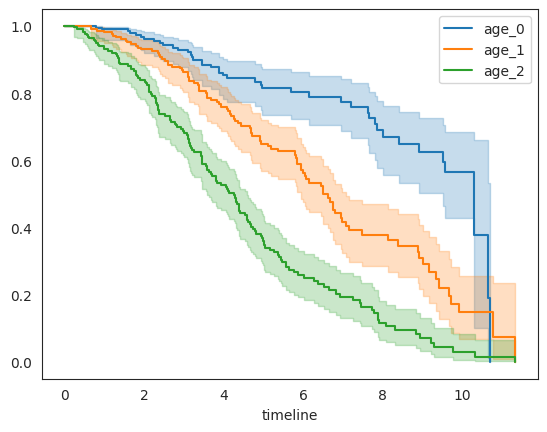

In [129]:
# 按年龄的分组
ages = np.array(visit_sta_first)[:,labels_visit_sta.index('age')]
data_rounds = gconst.get_data_rounds(ages,"q3")
print(data_rounds)
data_rounds_index = gconst.get_data_rounds_indexs(ages,data_rounds)
medium_time = get_medium_time(pdid_656,visit_sta_first,days_656,result_path,save,['age'],3)
print(medium_time)

In [130]:
print(data_rounds_index)

[2, 2, 0, 2, 1, 0, 0, 2, 2, 2, 0, 2, 1, 0, 2, 1, 0, 1, 2, 0, 0, 2, 1, 1, 0, 2, 1, 2, 2, 1, 2, 2, 0, 1, 2, 1, 1, 2, 2, 1, 0, 2, 1, 1, 1, 0, 1, 2, 1, 1, 2, 0, 2, 0, 0, 0, 1, 2, 0, 2, 0, 1, 2, 1, 1, 0, 1, 1, 2, 1, 0, 0, 1, 2, 0, 1, 1, 1, 1, 0, 1, 0, 1, 2, 0, 1, 2, 2, 2, 0, 1, 2, 1, 0, 1, 1, 2, 1, 2, 2, 1, 0, 2, 0, 0, 1, 2, 0, 2, 0, 1, 1, 0, 2, 0, 2, 1, 1, 0, 1, 1, 2, 1, 1, 0, 2, 1, 1, 0, 1, 2, 1, 0, 1, 2, 1, 1, 0, 2, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 2, 2, 2, 0, 0, 1, 0, 2, 1, 2, 2, 1, 0, 1, 0, 2, 2, 0, 2, 0, 1, 2, 0, 0, 1, 2, 0, 2, 2, 2, 1, 1, 2, 1, 1, 1, 0, 2, 1, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 2, 0, 1, 0, 1, 1, 1, 1, 2, 0, 0, 0, 2, 1, 2, 2, 1, 1, 0, 1, 1, 2, 1, 1, 1, 2, 0, 1, 2, 0, 2, 0, 1, 0, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 2, 0, 2, 0, 2, 0, 2, 1, 2, 2, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 0, 0, 0, 0, 2, 1, 2, 2, 2, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 2, 0, 0, 2, 0, 0, 2, 1, 0, 1, 2, 2, 1, 2, 0, 2, 0, 1, 1, 2, 1, 

In [131]:
# 数据分组 0是坏饮食组
feature_label = 'age'
groups = []
death_ages = np.array(days_656)[:,gconst.get_labels_days().index('death_age')]
visit_time = [float(death_ages[i])-float(ages[i]) for i in range(len(pdid_656))]
death = np.array(days_656)[:,gconst.get_labels_days().index('death')]
cur_medium_time = medium_time[feature_label][1]
print(cur_medium_time)
for i in range(len(data_rounds)):
    groups.append([[],[]])
for index,id in enumerate(pdid_656):
    q = data_rounds_index[index]
    
    if visit_time[index] < cur_medium_time[q][0] and death[index] == '1':
        if death[index] == '1':
            groups[q][0].append(id) # 0是坏饮食组
        # groups[q][0].append(id)
        
    else:
        groups[q][1].append(id)
sum0,sum1 = 0,0
for group in groups:
    sum0+=len(group[0])
    sum1+=len(group[1])
    print(len(group[0]),len(group[1]))
print(sum0,sum1)

[[10.284931506849315, 9.517808219178082, 10.693150684931506], [6.616438356164384, 5.936986301369863, 7.0849315068493155], [4.2684931506849315, 3.589041095890411, 4.594520547945206]]
40 177
72 144
97 126
209 447


In [132]:
all_0, all_1 = [],[]
for group in groups:
    all_0 += group[0]
    all_1 += group[1]
print(len(all_0),len(all_1))
groups.append([all_0,all_1])


209 447


## Examine whether there is a difference between the good diet group and the bad diet group

In [133]:
# 数据提取，好坏饮食组
print(np.array(diet_sta_mean)[:,1:].shape)
print(gconst.get_labels_statistics_diet()[1:])

(656, 26)
['water', 'protein', 'fat', 'carbohydrate', 'Calories', 'df', 'k', 'na', 'mg', 'ca', 'p', 'fe', 'zn', 'cu', 'mn', 'se', 'retinol', 'vitaminA', 'carotene', 'vitaminE', 'thiamine', 'riboflavin', 'nicotinic', 'ascorbic', 'dpi', 'dei']


In [134]:
# 计算区别
def get_diff_group_diet(diet_means,groups,result_path,pdid):
    '''按某指标分组，好坏饮食的区别检验'''
    diet_labels = gconst.get_labels_statistics_diet()[1:] #第一列为日期，不参与计算
    diet_means = np.array(diet_means)[:,1:] #第一列为日期，不参与计算
    df_labels = ['group','nutrition','shapiro0','shapiro1','levene','t_test','kruskal','mean0','mean1','std0','std1']
    results = []
    for group_index in range(len(groups)):
        diet_data_group0 = np.array([diet_means[i] for i in range(len(pdid)) if pdid[i] in groups[group_index][0]],dtype=float)
        diet_data_group1 = np.array([diet_means[i] for i in range(len(pdid)) if pdid[i] in groups[group_index][1]],dtype=float)
        for index,label in enumerate(diet_labels):
            data0 = diet_data_group0[:,index]
            data1 = diet_data_group1[:,index]
            n_test0 = stats.shapiro(data0)#正态性检验
            n_test1 = stats.shapiro(data1)#正态性检验
            levene = stats.levene(data0,data1)#方差齐性检验
            t_test = stats.ttest_ind(data0,data1,equal_var=False) # t检验
            kruskal = stats.kruskal(data0,data1) # kruskal检验
            mean0,mean1 = np.mean(data0),np.mean(data1)
            std0,std1 = np.std(data0),np.std(data1)
            result = [f'{feature_label}_{group_index}',f'{label}',n_test0[1],n_test1[1],levene[1],t_test[1],kruskal[1],mean0,mean1,std0,std1]
            results.append(result)
    df = pd.DataFrame(results,columns=df_labels)
    filename = f'{result_path}ttest.xlsx'
    with pd.ExcelWriter(filename) as writer:
        df.to_excel(writer,float_format='%.4f')
        logger.debug(f'result saved at {filename}')
get_diff_group_diet(diet_sta_mean,groups,result_path,pdid_656)

2024-04-05 11:04:37.305 | DEBUG    | __main__:get_diff_group_diet:27 - result saved at .//result/ttest.xlsx


## Does the diet vary by indicator


In [135]:
# 按年龄段分组
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import MultiComparison
diet_sta_mean_np = np.array(diet_sta_mean)
q = 3
# cols = gconst.get_labels_visit() + ['age','height','bmi','gfr']
cols = gconst.get_labels_statistics_visit()
res = {'label':labels_diet_sta[1:]}
for col in cols:
    res[col] = []

for col in cols: # 对于visit的每个指标，探究这个指标不同的患者，倾向于如何饮食
    print(col)
    # data离散化，如果是diab或者gender则不用离散化
    if col == 'diab' or col =='gender':
        data_rounds_index = np.array(visit_sta_first)[:,labels_visit_sta.index(col)]
    else:
        datas = np.array(visit_sta_first)[:,labels_visit_sta.index(col)]
        data_rounds = gconst.get_data_rounds(datas,f"q{q}") # data分组的上下界
        data_rounds_index = gconst.get_data_rounds_indexs(datas,data_rounds) # data分组的具体分组
    
    data_rounds_index = [i + 1 for i in data_rounds_index] # 最小的分组不能为0
    for index,diet_label in enumerate(labels_diet_sta): # 对于每个饮食营养指标，检验不同的分组是否有区别
        if(index == 0): # 第一列是date要跳过
            continue
        cur_data = diet_sta_mean_np[:,index] # 获取饮食均值
        # print(cur_data)
        cur_data = [float(i) for i in cur_data]
        data_concated = np.concatenate((np.array(cur_data).reshape(-1,1),np.array(data_rounds_index).reshape(-1,1)),axis=1) # 饮食均值和患者分组匹配
        df = pd.DataFrame(data_concated,columns=["data","group"])  
        
        #example8_2=pd.read_csv("example8_2.csv",encoding="gbk") 
        model = ols(formula='data~group',data=df).fit()  #拟合方差分析模型
        table = anova_lm(model,typ=1)
        # print(table)
        # print(table['PR(>F)']['group'])

        # 分别检验
        # mc = MultiComparison(df['data'],groups=df['group'])
        # print(mc.tukeyhsd(alpha=0.05))  
        
        res[col].append(table['PR(>F)']['group']) # 均值记录

# print(pd.DataFrame(res))
# 保存res
df_anova_visit_diet = pd.DataFrame(res)
filename = f'{result_path}anova_visit_diet.xlsx'
with pd.ExcelWriter(filename) as writer:
    df_anova_visit_diet.to_excel(writer,float_format='%.4f')
    logger.debug(f'result saved as {filename}')

Cl


CO2CP
WBC
Hb
Urea
Ca
K
Na
Scr
P
Albumin
hs-CRP
Glucose
Appetite
Weight
SBP
DBP
age
gender
diab
height
bmi
gfr


2024-04-05 11:04:42.089 | DEBUG    | __main__:<module>:52 - result saved as .//result/anova_visit_diet.xlsx


# cox test

In [136]:
# def do_cox(pdid,data,days,labels=gconst.get_labels_statistics_visit()):
#     data_append, labels_append = append_livedatas(pdid, data,days,labels)
#     df = pd.DataFrame(data_append,columns=labels_append)
#     cph = CoxPHFitter()
#     cph.fit(df,duration_col='live_time',event_col='death')
#     cph.print_summary()

# do_cox(pdid_656,visit_sta_first,days_656)


In [137]:
# 单变量分析
def do_cox_single(pdid,data,days,result_path,save=True): 
    '''单变量分析，返回分析结果和p值<0.05的列list'''
    results = []
    col_p_lt = []
    data_append, labels_append = append_livedatas(pdid,data,days)
    df = pd.DataFrame(data_append,columns=labels_append)
    for index,cur_label in enumerate(labels_visit_sta):
        df1 = df[[cur_label,'live_time','death']]
        cph = CoxPHFitter()
        cph.fit(df1,'live_time','death')
        df_summary = cph.summary
        results.append(df_summary)
        p = float(df_summary['p'])
        if p < 0.05:
            col_p_lt.append(cur_label)

    res = pd.concat(results)
    if save :
        filename = f'{result_path}sta_cox_single.xlsx'
        with pd.ExcelWriter(filename) as writer:
            res.to_excel(writer,float_format='%.4f')
            print(f'result saved as {filename}')
    return res,col_p_lt
res,col_p_lt = do_cox_single(pdid_656,visit_sta_first,days_656,result_path,save=True)
print(col_p_lt)

/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])


/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the fut

result saved as .//result/sta_cox_single.xlsx
['Cl', 'WBC', 'Urea', 'K', 'Na', 'Scr', 'P', 'Albumin', 'hs-CRP', 'Glucose', 'Appetite', 'Weight', 'SBP', 'DBP', 'age', 'diab', 'bmi']


/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/home/v-wuyueying/miniconda3/envs/esrd/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_

In [138]:
# 多变量分析
def do_cox_multi(pdid, data, days, labels,result_path,filename='sta_cox_multi.xlsx',save=True):
    '''多变量分析cox'''
    data_append, labels_append = append_livedatas(pdid,data,days,labels)
    df = pd.DataFrame(data_append,columns=labels_append)
    _,col_p_lt = do_cox_single(pdid,data,days,result_path,save=False)
    # print(col_p_lt)
    # col_p_lt.remove('bmi')
    print(col_p_lt)
    if 'Appetite' in col_p_lt:
        col_p_lt.remove('Appetite')
    df1 = df[(col_p_lt + ['live_time','death'])]
    cph = CoxPHFitter()
    cph.fit(df1,duration_col='live_time',event_col='death')
    df_summary = cph.summary
    col_p_lt = []
    for index,row in df_summary.iterrows():
        if row['p'] < 0.1:
            col_p_lt.append(index)
    res = df_summary
    if save:
        filename = f'{result_path}{filename}'
        with pd.ExcelWriter(filename) as writer:
            res.to_excel(writer,float_format='%.4f')
            print(f'result saved as {filename}')
    return res,col_p_lt
do_cox_multi(pdid_656,visit_sta_first,days_656,labels_visit_sta,result_path,save=True)


/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the fut

['Cl', 'WBC', 'Urea', 'K', 'Na', 'Scr', 'P', 'Albumin', 'hs-CRP', 'Glucose', 'Appetite', 'Weight', 'SBP', 'DBP', 'age', 'diab', 'bmi']
result saved as .//result/sta_cox_multi.xlsx


(             coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
 covariate                                                                
 Cl        -0.0140     0.9861    0.0124         -0.0383          0.0102   
 WBC        0.0347     1.0353    0.0297         -0.0236          0.0930   
 Urea      -0.0107     0.9894    0.0138         -0.0377          0.0163   
 K          0.0599     1.0617    0.0874         -0.1113          0.2312   
 Na        -0.0200     0.9802    0.0155         -0.0504          0.0104   
 Scr       -0.0005     0.9995    0.0003         -0.0011          0.0002   
 P          0.1097     1.1160    0.1663         -0.2163          0.4357   
 Albumin   -0.0724     0.9302    0.0150         -0.1018         -0.0429   
 hs-CRP     0.0010     1.0010    0.0054         -0.0096          0.0115   
 Glucose    0.0338     1.0344    0.0240         -0.0133          0.0809   
 Weight     0.0096     1.0096    0.0100         -0.0101          0.0292   
 SBP       -0.0075     0.

In [139]:
## 某一饮食营养对全因死亡率的影响

In [140]:
from lifelines.utils import find_best_parametric_model
def do_cox_single_diet(pdid, visit,diet, days,result_path,save=True):
    
    labels_diet = gconst.get_labels_statistics_diet()
    labels_visit = gconst.get_labels_statistics_visit()
    labels_for_pic = gconst.get_labels_statistics_diet_for_pic_with_unit()
    _, col_p_lt = do_cox_single(pdid,visit,days,result_path,save=False) # 单变量分析，获取调整变量
    data =np.concatenate([visit,diet],axis=1) # 拼接visit 和 diet
    data_append,label_append = append_livedatas(pdid,data,days,labels_visit + labels_diet)
    df = pd.DataFrame(data_append,columns=label_append)
    # print(df)
    results = []
    col_p_lt_diet = []
    for index,cur_label in tqdm(enumerate(labels_diet[1:])): # 不需要第一个date
        
        df1 = df[col_p_lt + [cur_label] + ['live_time','death']]
        cph = CoxPHFitter()
        cph.fit(df1,duration_col='live_time',event_col='death')
        df_summary = cph.summary
        cur_df_summary = df_summary[df_summary.index == cur_label] # 获取当前营养元素的行
        results.append(cur_df_summary)
        p = float(df_summary['p'][cur_label])
        if p < 0.05:
            col_p_lt_diet.append(cur_label)
        hazard = list(cph.predict_partial_hazard(df1))
        cur_data = list(df1[cur_label])
        cur = np.concatenate([np.array(hazard,dtype=float).reshape(-1,1),np.array(cur_data,dtype=float).reshape(-1,1)],axis=1) # 合并
        cur_df = pd.DataFrame(cur,columns=['hazard',cur_label])
        # print(cur_df)
        # break
        plt.figure()
        sns.set_style('white')
        # sns.scatterplot(x=cur_data,y=hazard)
        # sns.color_palette("Spectral", as_cmap=True)
        # sns.regplot(data=cur_df,x=f'{cur_label}',y=f'hazard',scatter_kws={"alpha":.2,"color":"black"})
        # 删除值大于15的点
        cur_df_cur = pd.DataFrame(cur_df[cur_df['hazard']<8])

        ax = sns.relplot(data=cur_df_cur,x=f'{cur_label}',y=f'hazard',kind='scatter', alpha=0.5,color='black')
        ax.set_xlabels(f'{labels_for_pic[labels_diet.index(cur_label)]}',fontsize=20)
        ax.set_ylabels(f'HR',fontsize=20)
        # xy标签字号设置
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        # ax.axes_style()
        # 字号

        # plt.savefig(f'{result_path}hazard/{cur_label}.svg',dpi=300)
        plt.savefig(f'{result_path}{cur_label}.pdf',dpi=300,bbox_inches='tight')
        plt.savefig(f'{result_path}{cur_label}.png',dpi=300,bbox_inches='tight')
        plt.savefig(f'{result_path}{cur_label}.svg',dpi=300,bbox_inches='tight')

        plt.close()
        # break
        # cph.plot_cumulative_hazard()
        # print(hazard,cur_data)
        # print(cur_df)  
        # break  
    res = pd.concat(results)
    if save:
        filename = f'{result_path}sta_cox_diet_single_first.xlsx'
        with pd.ExcelWriter(filename) as writer:
            res.to_excel(writer,float_format='%.4f')
            print(f'result saved as {filename}')

    return res,col_p_lt_diet
import os
# mkdir
os.makedirs(f'{result_path}/hazard/',exist_ok=True)
do_cox_single_diet(pdid_656,visit_sta_first,diet_sta_first,days_656,f'{result_path}/hazard/',save=True)
    

/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])


/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the fut

result saved as .//result//hazard/sta_cox_diet_single_first.xlsx


(                coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
 covariate                                                                   
 water        -0.0004     0.9996    0.0003         -0.0009          0.0001   
 protein      -0.0032     0.9968    0.0070         -0.0168          0.0105   
 fat           0.0020     1.0020    0.0042         -0.0062          0.0102   
 carbohydrate  0.0018     1.0018    0.0014         -0.0008          0.0045   
 Calories      0.0004     1.0004    0.0003         -0.0002          0.0009   
 df            0.0244     1.0247    0.0119          0.0012          0.0476   
 k            -0.0002     0.9998    0.0002         -0.0005          0.0002   
 na            0.0001     1.0001    0.0001         -0.0000          0.0003   
 mg            0.0001     1.0001    0.0012         -0.0021          0.0024   
 ca           -0.0004     0.9996    0.0003         -0.0010          0.0003   
 p            -0.0002     0.9998    0.0004         -0.0010      

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

## cox for different albumin group

In [141]:


visit_sta_first_df = pd.DataFrame(visit_sta_first,columns=labels_visit_sta)
albumin_data_rounds = gconst.get_data_rounds(visit_sta_first_df['Albumin'])
albumin_groups = gconst.get_data_rounds_indexs(visit_sta_first_df['Albumin'],albumin_data_rounds)

# 不同albumin组的做cox，保存到 sta_cox_multi_stage_i.xlsx
# do_cox_multi(pdid_656,visit_sta_first,days_656,labels_visit_sta,result_path,save=True)


for stage in range(3):
    # 统计 albumin_groups 中 值为 stage 的 index
    cur_index = [i for i in range(len(pdid_656)) if albumin_groups[i] == stage ]
    # 筛选值
    cur_visit_sta_first = [visit_sta_first[i] for i in cur_index]
    cur_diet_sta_first = [diet_sta_first[i] for i in cur_index]
    cur_days_656 = [days_656[i] for i in cur_index]
    cur_result_path = f'{result_path}/hazard/{stage}/'
    import os
    if not os.path.exists(cur_result_path):
        os.makedirs(cur_result_path)
    do_cox_single_diet(cur_index,cur_visit_sta_first,cur_diet_sta_first,cur_days_656,cur_result_path,save=True)
    # do_cox_multi(cur_index, cur_visit_sta_first,cur_days_656, labels_visit_sta, result_path=result_path, filename=f'sta_cox_multi_stage{stage}.xlsx',save=True)


/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])


/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the fut

result saved as .//result//hazard/0/sta_cox_diet_single_first.xlsx


/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the fut

result saved as .//result//hazard/1/sta_cox_diet_single_first.xlsx


/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the fut

result saved as .//result//hazard/2/sta_cox_diet_single_first.xlsx


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [142]:
visit_sta_first_df = pd.DataFrame(visit_sta_first,columns=labels_visit_sta)
albumin_data_rounds = gconst.get_data_rounds(visit_sta_first_df['Albumin'])
albumin_groups = gconst.get_data_rounds_indexs(visit_sta_first_df['Albumin'],albumin_data_rounds)

# 不同albumin组的做cox，保存到 sta_cox_multi_stage_i.xlsx
# do_cox_multi(pdid_656,visit_sta_first,days_656,labels_visit_sta,result_path,save=True)


for stage in range(3):
    # 统计 albumin_groups 中 值为 stage 的 index
    cur_index = [i for i in range(len(pdid_656)) if albumin_groups[i] == stage ]
    # 筛选值
    cur_visit_sta_first = [visit_sta_first[i] for i in cur_index]
    cur_days_656 = [days_656[i] for i in cur_index]
    do_cox_multi(cur_index, cur_visit_sta_first,cur_days_656, labels_visit_sta, result_path=result_path, filename=f'sta_cox_multi_stage{stage}.xlsx',save=True)

/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the fut

/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the fut

['Cl', 'K', 'Na', 'Scr', 'hs-CRP', 'Appetite', 'Weight', 'SBP', 'DBP', 'age', 'gfr']
result saved as .//result/sta_cox_multi_stage0.xlsx


/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the fut

['Cl', 'Urea', 'Ca', 'Na', 'Scr', 'Albumin', 'SBP', 'DBP', 'age', 'diab', 'gfr']
result saved as .//result/sta_cox_multi_stage1.xlsx


/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the fut

['Scr', 'Albumin', 'Glucose', 'Appetite', 'DBP', 'age', 'diab', 'gfr']
result saved as .//result/sta_cox_multi_stage2.xlsx


/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])
/tmp/ipykernel_4160600/3512376114.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p = float(df_summary['p'])


# about visits

## statistc the visit

In [143]:
#统计随访

dates_visit = date_656
dates_diet = [np.array(diet_sta[i])[:,0] for i in range(len(diet_sta))]
date_first = [i[0] for i in dates_visit]
dates = dates_diet

def get_interval_count(dates,date_first,output=False,interval = 180):
    '''统计一个患者最远有几次记录
    @param dates: 所有患者的全部的随访/饮食记录的时间
    @param date_first:所有患者的首次随访时间，作为初始点
    @param output:是否输出
    @param interval: 统计间隔，90/180
    @return 记录属于第几段 '''
    date_first = [datetime.datetime.strptime(i,'%Y/%m/%d') for i in date_first]
    have6 = [0 for i in range(7)]
    have6_180 = [0 for i in range(7)]
    visit_count = []

    for j in range(len(dates)):
        cur_dates_str = dates[j]
        # print(cur_dates_str)
        cur_dates = [datetime.datetime.strptime(cur_date_str,'%Y/%m/%d') for cur_date_str in cur_dates_str]
        
        cur_dates_relative = [max(0,(cur_dates[i] - date_first[j]).days) for i in range(len(cur_dates))] # 记录时间 - 第一次就诊时间
        cur_belong = [i // 90 for i in cur_dates_relative]
        cur_belong_180 = [i // 180 for i in cur_dates_relative]
        visit_count.append([i // interval for i in cur_dates_relative])
        # if [i // interval for i in cur_dates_relative].count(-1)!=0:
        #     print("no",cur_dates_str)

        for i in range(7):
            if max(cur_belong)>=i:
                have6[i] += 1
        for i in range(7):
            if max(cur_belong_180)>=i:
                have6_180[i] += 1
    
    if output:
        print("间隔90天",have6)
        print("间隔180天",have6_180)
    return visit_count
print('date_diet')
visit_count_diet = get_interval_count(dates_diet, date_first,output=True)
print('date_visit')
# visit_count_visit = get_interval_count(dates_visit, date_first,output=True)

date_diet
间隔90天 [656, 599, 563, 533, 517, 489, 469]
间隔180天 [656, 563, 517, 469, 414, 364, 316]
date_visit


## Discrete follow-up data

In [144]:
# 每位患者随访分7次，对应 0-36月，
def get_time_average(data, interval_belong,max_interval_index = 7,filled=False):
    '''对数据按时间间隔取平均
    @param data: 数据 [p visit feature]
    @param interval_belong: 数据对应的interval
    @param max_interval_index: 最大的interval_index 如果是0-6个月，那就是7个interval
    '''
    if type(data[0][0][0]) is np.str_:
        print('diet data, removed date')
        data = [np.array(data_i)[:,1:] for data_i in data] # #去除第一列
    
    interval_data = [[[] for _ in range(max_interval_index)] for _ in range(len(interval_belong))]
    # print(interval_data)
    for i,(cur_p_data, cur_p_interval) in enumerate(zip(data,interval_belong)):
        for j,  (cur_data, cur_interval) in enumerate(zip(cur_p_data, cur_p_interval)):
            if cur_interval < max_interval_index:
                interval_data[i][cur_interval].append(cur_data)
        # 后向填充
        if filled:
            for j, cur_interval_data in enumerate(interval_data[i]):
                if len(interval_data[i][j]) == 0:
                    interval_data[i][j] += interval_data[i][j - 1]

    # for p in range(656):
    #     print([len(i) for i in interval_data[p]])
    # 求平均
    interval_data_average = [[[] for _ in range(max_interval_index)] for _ in range(len(interval_belong))]
    for i,cur_p_interval_data in enumerate(interval_data):
        for j, cur_interval_data in enumerate(cur_p_interval_data):
            if(len(cur_interval_data)!= 0):
                interval_data_average[i][j].append(np.mean(np.array(cur_interval_data,dtype=float),axis=0))
    return interval_data_average

interval_data = get_time_average(diet_sta,visit_count_diet)
# print(interval_data[0])
# for p in range(656):
    # print([len(i) for i in interval_data[p]])
# print(interval_data[0][0])
# print(np.array(interval_data).shape)


diet data, removed date


In [145]:
interval_data_time_average = get_time_average(diet_sta,visit_count_diet,max_interval_index=100) #[656,100,1,26]

diet data, removed date


In [146]:
print(len(interval_data_time_average[0]))
def get_time_average_for_p(time_average_data,):
    '''数据类型 [656,100,1,26] 转换为 [656,26], 转换为[656,27]
    '''
    p_len = len(time_average_data)
    diet_mean = []
    for time_average_p in time_average_data:
        cur_len ,cur_diet_visit = 0, []
        for time_average_p_visit in time_average_p:
            # print(111111)
            # print(len(time_average_p_visit))
            # print(time_average_p_visit)
            if(len(time_average_p_visit)!=0):
                cur_len += 1
                cur_diet_visit.append(time_average_p_visit[0])
        cur_diet_mean = np.array(cur_diet_visit).mean(axis=0)
        diet_mean.append(cur_diet_mean)
    diet_mean = np.array(diet_mean)
    diet_mean = np.insert(diet_mean,0,[0 for _ in range(len(diet_mean))],axis = 1) # 第一列表示日期
    return diet_mean
diet_sta_mean_time = get_time_average_for_p(interval_data_time_average)

print(diet_sta_mean_time.shape)



100
(656, 27)


In [147]:
# # 对于每个指标，每个间隔，每位患者的数据
def get_interval_data(data,labels,max_interval_index = 7):
    if labels[0] == 'date':
        labels = labels[1:]
    # print(labels)
    res = [[[] for _ in range(max_interval_index)] for _ in range(len(labels))]
    for i, cur_p_data in enumerate(data):
        # print(np.array(cur_p_data).shape)
        for j, cur_p_interval in enumerate(cur_p_data):
            if len(cur_p_interval) != 0:
                for k, label in enumerate(labels):
                    res[k][j].append(data[i][j][0][k])
    return res
        
# labels = gconst.get_labels_statistics_diet()
# res = get_interval_data(interval_data,labels)
# print(np.array(res).shape)

## avona test

In [148]:

def avona(data,labels,result_path,filename='interval_diet_anova.xlsx',save=True):
    '''对数据进行avona检验'''
    if labels[0] == 'date':
        labels = labels[1:]
    res = {'col':labels,'p':[]}
    Path(f'{result_path}interval_diet').mkdir(parents=True, exist_ok=True)
    Path(f'{result_path}interval_diet/interval_diet_reg').mkdir(parents=True, exist_ok=True)
    for i,label in enumerate(labels):
        print(label)
        cur_data = []
        cur_label = []
        for j, cur in enumerate(data[i]):
            cur_data += cur
            cur_label += [j for _ in range(len(cur))]
        # print(len(cur_data),len(cur_label))
        cur_data_concated = np.concatenate((np.array(cur_data,dtype=float).reshape(-1,1),np.array(cur_label).reshape(-1,1)),axis=1)
        cur_df = pd.DataFrame(cur_data_concated,columns=['data','group'])
        # print(cur_df)
        
        model = ols(formula='data~group',data=cur_df).fit()
        table = anova_lm(model,typ=1)
        # print(table)
        mc = MultiComparison(cur_df['data'],groups=cur_df['group'])
        # print(mc.tukeyhsd(alpha=0.05))  
        
        res['p'].append(table['PR(>F)']['group']) # 均值记录
        # sns.set_theme(style="whitegrid")
        sns.set_theme()
        plt.figure(figsize=(6,4),dpi=200)
        # sns.catplot(data=cur_df, x="group", y="data", zorder=1,kind="point",capsize=.2, palette="YlGnBu_d", errorbar="se")

        sns.violinplot(y=[float(i) for i in cur_df['data']],x=cur_label,bw=.15,palette="light:g")

        # sns.catplot(data=cur_df, x="group", y="data", zorder=1,palette="light:g")
        plt.title(f"{label} (p = {table['PR(>F)']['group']:.2f})")
        plt.savefig(f'{result_path}interval_diet/{label}.png')
        plt.close()

        plt.figure(figsize=(6,6),dpi=200)
        # plt.figure()
        # sns.regplot(xdata=cur_df, x="group", y="data",scatter=False, truncate=False, order=2, color=".2",x_ci='sd')
        ax = sns.catplot(data=cur_df, x="group", y="data", kind="point",capsize=.2, palette="YlGnBu_d", errorbar="se")
        # sns.relplot(data=cur_df, x="group", y="data",)
        # ax.fig.suptitle("title")
        ax.fig.suptitle(f"{label} (p = {table['PR(>F)']['group']:.2f})")
        # plt.title(f"{label} (p = {table['PR(>F)']['group']:.2f})")
        plt.savefig(f'{result_path}interval_diet/interval_diet_reg/{label}.png')
        plt.close()
        # break
    if save:
        filename = f'{result_path}interval_diet_anova.xlsx'
        with pd.ExcelWriter(filename) as writer:
            pd.DataFrame(res).to_excel(writer,float_format='%.4f')
            print(f'result saved as {filename}')
    return res
# avona_res = avona(res,labels,result_path)

## Subdietary Indicators, High, Medium, Low, Test Medical Indicator Changes

In [150]:
dates_visit = date_656
dates_diet = [np.array(diet_sta[i])[:,0] for i in range(len(diet_sta))]
date_first = [i[0] for i in dates_visit]
# 获取36个月随访饮食指标，并求平均
interval_diet_all = get_interval_count(dates_diet, date_first,output=False)
# print(interval_diet_all)
interval_diet_average = get_time_average(diet_sta,interval_diet_all)
# 饮食指标分高中低档，每个指标，每个interval，找到患者和高中低档的对应关系


# 获取36个月医疗指标，并求平均
interval_visit_all = get_interval_count(dates_visit, date_first,output=False)
# print(interval_visit_all)
print('ok')

interval_visit_average = get_time_average(visit_sta,interval_visit_all)
# print(interval_visit_average[0])
print(len(interval_diet_average[0][0][0]))
# 分别统计7个阶段医疗指标
# 检验

diet data, removed date
ok
26


In [151]:
def get_average_missing(interval_data_average,pdid):
    '''存在缺失数据的情况下获取平均值。如果有的患者没有记录，则用其他患者的均值补充，有3位患者没有记录。
    @param interval_data_average: 656 7 1 25 （1有可能是0）
    @param pdid: 患者id
    @return diet_average: 每位患者的饮食营养平均值 656 25 '''
    diet_average = []
    indexs_miss = []
    for i in range(len(pdid)):
        avg_cur = []    
        for j in range(7):
            if len(interval_data_average[i][j]) != 0:
                # print(len(interval_diet_average[i][j][0]))
                avg_cur.append(interval_data_average[i][j][0])
        # print(len(avg_cur))
        if(len(avg_cur)!= 0):
            diet_average.append(np.mean(avg_cur,axis=0))
        else:
            indexs_miss.append(i)
        # break
    diet_average_allmean = np.mean(diet_average,axis=0)
    for i in indexs_miss:
        diet_average.insert(i,diet_average_allmean)
    # for i in indexs_miss:
    #     print(diet_average[i])
    return np.array(diet_average)

In [153]:
print(np.array(diet_sta_first).shape)
print(labels_diet_sta)
print(len(diet_sta[0][0]))


(656, 27)
['date', 'water', 'protein', 'fat', 'carbohydrate', 'Calories', 'df', 'k', 'na', 'mg', 'ca', 'p', 'fe', 'zn', 'cu', 'mn', 'se', 'retinol', 'vitaminA', 'carotene', 'vitaminE', 'thiamine', 'riboflavin', 'nicotinic', 'ascorbic', 'dpi', 'dei']
27


# output table

In [154]:
# 输出表格 diet_mean visit_first event livetime
# ['date', 'water', 'protein', 'fat', 'carbohydrate', 'Calories', 'df', 'k', 'na', 'mg', 'ca', 'p', 'fe', 'zn', 'cu', 'mn', 'se', 'retinol', 'vitaminA', 'carotene', 'vitaminE', 'thiamine', 'riboflavin', 'nicotinic', 'ascorbic', 'dpi', 'dei']

def output_groupby(group_by,q,labels_visit,labels_diet,visit_data,diet_data,days,pdid,result_path):
    '''按照group_by分组，输出数据'''


    
    diet_data = np.array(diet_data)
    visit_data_events,labels_appended = append_livedatas(pdid,visit_data,days,labels_visit)
    visit_data_events = np.array(visit_data_events)
    
    # 删除date一列
    if labels_diet[0] == 'date':
        labels_diet = labels_diet[1:]
        diet_data = diet_data[:,1:]
    
    # 
    pos = labels_appended.index('hs-CRP')
    labels_appended[pos] = 'hsCRP'

    group_targets = np.array(visit_sta_first)[:,labels_visit_sta.index(group_by)]
    data_rounds = gconst.get_data_rounds(group_targets,f"q{q}")
    data_rounds_index = gconst.get_data_rounds_indexs(group_targets,data_rounds)
    # medium_time = get_medium_time(pdid_656,visit_sta_first,days_656,result_path,save,['age'],3)
    # print(medium_time)
    data_labels = ['stage'] + labels_diet + labels_appended
    groups = np.array(data_rounds_index,dtype=str).reshape(-1,1)
    datas = np.concatenate((groups, diet_data, visit_data_events),axis = 1)
    print(datas.shape)
    print(data_labels)
    datas_df = pd.DataFrame(datas,columns=data_labels)
    div_dict = {'water':100,'protein':1,'fat':10,
                'carbohydrate':1,'Calories':10,'df':1,'k':10,'na':100,
                'mg':10,'ca':100,'p':10,'fe':1,'zn':1,'cu':1,
                'mn':1,'se':1,'retinol':10,'vitaminA':100,
                'carotene':100,'vitaminE':1,'thiamine':1,'riboflavin':1,
                'nicotinic':1,'ascorbic':1,'dpi':0.1,'dei':1,'hsCRP':1}
    for key in div_dict.keys():
        datas_df[key] = datas_df[key].astype(float) / div_dict[key]
        # datas_df[key] = datas_df[key].astype(float) / 1
    

    for gr in range(q + 1):
        cur_df = datas_df[datas_df['stage'] == str(gr)]
        if gr == q:
            cur_df = datas_df
        print(len(cur_df))
        filename = f'{result_path}group_by_{group_by}_{gr}.csv'


        
        
        
        cur_df.to_csv(filename, index=False)
        print(f'result saved as {filename}')



        # 分别保存
        for diet_label in labels_diet:
            sub_labels = ['stage',diet_label] + labels_appended
            sub_df = cur_df[sub_labels]
            
            sub_df.columns = ['stage','data_col'] + labels_appended
            # remove stage
            sub_df = sub_df.drop(columns=['stage'])

            filename = f'{result_path}group_by_{group_by}_{diet_label}_{gr}.csv'
            sub_df.to_csv(filename, index=False)

            # break

target_groupby = ['Albumin','age','DBP','SBP','diab']
target_q = [3,3,3,3,2]


target_groupby = ['Albumin']
target_q = [3]
output_path = f'{project_path_prefix}/result/statistics_r/group_data_time_new/'
Path(output_path).mkdir(parents=True, exist_ok=True)
for (cur_groupby,cur_q) in zip(target_groupby,target_q):
    # output_groupby(cur_groupby,cur_q,labels_visit_sta,labels_diet_sta,visit_sta_first,diet_sta_mean_time,days_656,pdid_656,result_path+'group_data_time/')
    
    output_groupby(cur_groupby,cur_q,labels_visit_sta,labels_diet_sta,visit_sta_first,diet_sta_mean_time,days_656,pdid_656,output_path)

(656, 52)
['stage', 'water', 'protein', 'fat', 'carbohydrate', 'Calories', 'df', 'k', 'na', 'mg', 'ca', 'p', 'fe', 'zn', 'cu', 'mn', 'se', 'retinol', 'vitaminA', 'carotene', 'vitaminE', 'thiamine', 'riboflavin', 'nicotinic', 'ascorbic', 'dpi', 'dei', 'Cl', 'CO2CP', 'WBC', 'Hb', 'Urea', 'Ca', 'K', 'Na', 'Scr', 'P', 'Albumin', 'hsCRP', 'Glucose', 'Appetite', 'Weight', 'SBP', 'DBP', 'age', 'gender', 'diab', 'height', 'bmi', 'gfr', 'live_time', 'death']
217
result saved as .//result/statistics_r/group_data_time_new/group_by_Albumin_0.csv
222
result saved as .//result/statistics_r/group_data_time_new/group_by_Albumin_1.csv
217
result saved as .//result/statistics_r/group_data_time_new/group_by_Albumin_2.csv
656
result saved as .//result/statistics_r/group_data_time_new/group_by_Albumin_3.csv


# Baseline information statistics

In [155]:
import collections
# 按基线白蛋白分组
def get_labels_dict_statistics_diet_for_tab():
    return {'date': 'Date', 'water': 'Water', 'protein': 'Protein', 'fat': 'Fat', 'carbohydrate': 'Carbohydrate', 'Calories': 'Calories', 'df': 'Df', 'k': 'K', 'na': 'Na', 'mg': 'Mg', 'ca': 'Ca', 'p': 'P', 'fe': 'Fe', 'zn': 'Zn', 'cu': 'Cu', 'mn': 'Mn', 'se': 'Se', 'retinol': 'Retinol', 'vitaminA': 'VitaminA', 'carotene': 'Carotene', 'vitaminE': 'VitaminE', 'thiamine': 'Thiamine', 'riboflavin': 'Riboflavin', 'nicotinic': 'Nicotinic', 'ascorbic': 'Ascorbic', 'dpi': 'DPI', 'dei': 'DEI'}
def get_baseline_sta_group_by(visit_first,diet_first,labels_visit,labels_diet,resule_path, target_col = 'Albumin',q=3,filename='baseline_sta.xlsx'):
    pos = labels_visit.index('hs-CRP')
    labels_visit = list(labels_visit)
    labels_visit[pos] = 'hsCRP'

    visit_first = np.array(visit_first)
    if labels_diet[0] == 'date':
        labels_diet = labels_diet[1:]
        diet_first  = np.array(diet_first)[:,1:]
    # 获取目标基线数据
    target_data = visit_first[:,labels_visit.index(target_col)]
    # 按目标基线数据分组
    data_rounds = gconst.get_data_rounds(target_data,'q'+str(q))
    data_stage = gconst.get_data_rounds_indexs(target_data,data_rounds)
    print(f'data rounds: {data_rounds}')
    counter = collections.Counter(data_stage)
    print(f'data counter: {counter}')
    # 患者分组 [col, datas]
    data_merge = np.concatenate((visit_first,diet_first,np.array(data_stage).reshape(-1,1)),axis=1)
    labels_merge = labels_visit + labels_diet + ['group']
    print(data_merge.shape,len(labels_merge))
    data_merge_df = pd.DataFrame(data_merge,dtype = float, columns=labels_merge)
    grouped_data_df = data_merge_df.groupby('group')

    # 对于每个group，输出一下
    for group_index, group_data in grouped_data_df:
        print(f'group {group_index}')
        print(f'sum of diabetes: {sum(group_data["diab"])}, ratio: {sum(group_data["diab"])/len(group_data):.2f}')
        print(f'sum of female: {len(group_data) - sum(group_data["gender"])}, ratio: {(1 - sum(group_data["gender"])/len(group_data)):.2f}')
    # for all
    print(f'group all')
    print(f'sum of diabetes: {sum(data_merge_df["diab"])}, ratio: {sum(data_merge_df["diab"])/len(data_merge_df):.2f}')
    print(f'sum of female: {len(data_merge_df) - sum(data_merge_df["gender"])}, ratio: {(1 - sum(data_merge_df["gender"])/len(data_merge_df)):.2f}')


    means = grouped_data_df.mean()
    stds = grouped_data_df.std()
    mean_all = data_merge_df.mean().drop(labels=['group']) # 删除最后一行group
    std_all = data_merge_df.std().drop(labels=['group'])
    ps = []
    group_ps = []
    # 检验
    for col in labels_visit + labels_diet:
        model = ols(formula=f'{col}~group',data=data_merge_df).fit()
        table = anova_lm(model,typ=1)
        p_val = table['PR(>F)']['group']
        ps.append(p_val)

        mc = MultiComparison(data_merge_df[col],groups=data_merge_df['group'])
        res_group = mc.tukeyhsd(alpha=0.05)
        res_group = ['y' if i else 'n' for i in res_group.reject]
        group_ps.append(''.join(res_group))
        # print(group_ps)
        # break
    means, stds = means.transpose(), stds.transpose()
    ps = pd.DataFrame(np.array(ps).reshape(-1,1),columns=['p'],index=means.index)
    inner_ps = pd.DataFrame(np.array(group_ps).reshape(-1,1),columns=['inner_p'],index=means.index)
    print(means.shape, mean_all.shape,ps.shape)
    res = pd.concat([means,stds,mean_all,std_all,ps,inner_ps],axis=1)
    res.columns = [f'mean{i}' for i in range(3)] + [f'std{i}' for i in range(3)] + ['mean3','std3','p','inner_p']

    # 增加一列p_str, 如果p<0.001, p_str = "<0.001", 如果p<0.01, p_str = "<0.01",否则p_str = p
    res['p_str'] = res['p'].apply(lambda x: '<0.001' if x < 0.001 else '<0.01' if x < 0.01 else f'{x:.2f}')
    # 增加一列order, 用于排序, Albumin、age、gender、height、weight、BMI、diab、SBP、DBP、WBC、Hb、Urea、Scr、K、Na、Cl、P、hs-Crp、Glucose、CO2CP分别为1-20
    res['unit'] = ["mmol/L", "mmol/L", "$\times 10^{9}$/L", "g/L", "mmol/L", "mmol/L", "mmol/L", "mmol/L", "umol/L", "mmol/L", "g/L", "mg/L", "mmol/L","g", "kg", "mmHg", "mmHg", "year", "male", "yes", "cm", "-", "ml/min", "g/d", "g/d", "g/d", "g/d", "kcal/d", "g/d", "mg/d", "mg/d", "mg/d", "mg/d", "mg/d", "mg/d", "mg/d", "mg/d", "mg/d", "mg/d", "ug/d", "ugRAE/d", "ug/d", "mg/d", "mg/d", "mg/d", "mg/d", "mg/d", "g/(kg·d)", "kcal/(kg·d)"]

    order_list = [
    'Albumin',  # 白蛋白
    'age', 'gender', 'height', 'Weight', 'bmi', 'diab',  # 年龄、性别、身高、体重、BMI、糖尿病
    'SBP', 'DBP',  # 收缩压、舒张压
    'WBC', 'Hb', 'Urea', 'Scr', 'K', 'Na', 'Cl', 'Ca', 'P', 'hsCRP', 'Glucose', 'CO2CP',  # 白细胞计数、血红蛋白、尿素、血清肌酐、钾、钠、氯、钙、磷、高敏C反应蛋白、葡萄糖、二氧化碳结合能力
    'Appetite', 'gfr'  # 食欲、肾小球滤过率
    ]

    visit_labels_dict = gconst.get_labels_dict_statistics_visit_for_tab()
    diet_labels_dict = get_labels_dict_statistics_diet_for_tab()
    # print(res)
    filename = f'{result_path}{filename}'
    with pd.ExcelWriter(filename) as writer:
            res.to_excel(writer,float_format='%.2f',index=True)
    print(f'result saved as {filename}')

    # 前面的25个指标按照order_list排序，每行输出index, Unit, mean3, std3, mean0, std0, mean1, std1, mean2, std2, p_str,latex表格格式
    for cur_visit_label in order_list:
        cur_visit_label_output = visit_labels_dict[cur_visit_label]
        cur_res = res.loc[cur_visit_label]
        cur_res = cur_res[['unit','mean3','std3','mean0','std0','mean1','std1','mean2','std2','p_str']]
        print(f'{cur_visit_label_output} & {cur_res["unit"]} & {cur_res["mean3"]:.2f} & {cur_res["std3"]:.2f} & {cur_res["mean0"]:.2f} & {cur_res["std0"]:.2f} & {cur_res["mean1"]:.2f} & {cur_res["std1"]:.2f} & {cur_res["mean2"]:.2f} & {cur_res["std2"]:.2f} & {cur_res["p_str"]} \\\\')
    for cur_diet_label in labels_diet_sta:
        if cur_diet_label == 'date':
            continue
        cur_diet_label_output = diet_labels_dict[cur_diet_label]
        cur_res = res.loc[cur_diet_label]
        cur_res = cur_res[['unit','mean3','std3','mean0','std0','mean1','std1','mean2','std2','p_str']]
        print(f'{cur_diet_label_output} &{cur_res["unit"]} & & {cur_res["mean3"]:.2f} & {cur_res["std3"]:.2f} & {cur_res["mean0"]:.2f} & {cur_res["std0"]:.2f} & {cur_res["mean1"]:.2f} & {cur_res["std1"]:.2f} & {cur_res["mean2"]:.2f} & {cur_res["std2"]:.2f} & {cur_res["p_str"]} \\\\')
# 统计按白蛋白分组后，各个基线指标的特征

get_baseline_sta_group_by(visit_sta_first,diet_sta_first,labels_visit_sta,labels_diet_sta,'Albumin',filename='baseline_sta_Albumin.xlsx')
get_baseline_sta_group_by(visit_sta_mean,diet_sta_mean_time,labels_visit_sta,labels_diet_sta,'Albumin',filename='baseline_mean_sta_Albumin.xlsx')

data rounds: [(19.9, 35.215), (35.215, 39.5), (39.5, 51.3)]
data counter: Counter({1: 222, 0: 217, 2: 217})
(656, 50) 50
group 0.0
sum of diabetes: 121.0, ratio: 0.56
sum of female: 100.0, ratio: 0.46
group 1.0
sum of diabetes: 76.0, ratio: 0.34
sum of female: 117.0, ratio: 0.53
group 2.0
sum of diabetes: 47.0, ratio: 0.22
sum of female: 110.0, ratio: 0.51
group all
sum of diabetes: 244.0, ratio: 0.37
sum of female: 327.0, ratio: 0.50
(49, 3) (49,) (49, 1)
result saved as .//result/baseline_sta_Albumin.xlsx
Albumin & g/L & 37.15 & 4.90 & 31.58 & 3.00 & 37.56 & 1.20 & 42.29 & 2.12 & <0.001 \\
Age & year & 59.11 & 15.78 & 63.39 & 14.03 & 60.27 & 15.85 & 53.64 & 15.84 & <0.001 \\
Gender & male & 0.50 & 0.50 & 0.54 & 0.50 & 0.47 & 0.50 & 0.49 & 0.50 & 0.34 \\
Height & cm & 162.60 & 9.46 & 162.86 & 8.68 & 161.89 & 10.47 & 163.08 & 9.10 & 0.81 \\
Weight & kg & 61.17 & 11.95 & 59.95 & 12.13 & 60.44 & 11.58 & 63.13 & 11.95 & <0.01 \\
BMI & - & 23.19 & 5.89 & 22.50 & 3.66 & 23.42 & 8.71 & 23.66